In [1]:
# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN
import duckdb as dd

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#definindo quantidade de linhas e colunas visiveis
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

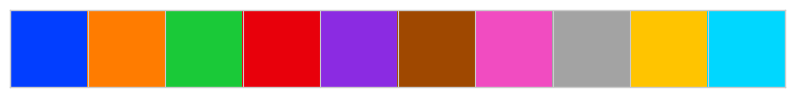

In [2]:
# Graficos ############################
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

plt.style.use('dark_background')
plt.style.use('seaborn-v0_8-whitegrid')

import seaborn as sns
custom_palette = sns.color_palette("bright")
sns.palplot(custom_palette)
sns.set_palette("bright")
sns.set_style('whitegrid') #cor da grade(fundo)

# Definindo o estilo de fonte e tema
import matplotlib.font_manager as fm #para alterar as fontes dos graficos
fonte = fm.FontProperties(family="Calibri", style="italic")
%matplotlib inline

In [3]:
# Copia e cola
import pyperclip

# Manipulação de Strings
from unidecode import unidecode #unidecode(string)
import re # Regex

# Controle de Erros
import traceback

# Manipualação de datas
from datetime import *

In [4]:
# Carregando minhas funções de analise de dados e criação de modelos
import requests

url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'funcoes_estatisticas' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'ML_supervised_learning' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

def aval_modelo_corte_tabela(y_true, y_probs_positivas, beta = 1.5, pontos_de_corte = np.arange(10, 100, 10)):
    y_probs_positivas = np.array(y_probs_positivas)
    # Inicializando um DataFrame para armazenar as métricas
    fd = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp'])

    # Loop pelos pontos de corte
    for threshold in pontos_de_corte:
        previsoes_personalizadas = (y_probs_positivas >= threshold).astype(int)

        # Calculando os valores de tn, fp, fn, tp
        tn = len(np.where((previsoes_personalizadas == 0) & (y_true == 0))[0])
        fp = len(np.where((previsoes_personalizadas == 1) & (y_true == 0))[0])
        
        fn = len(np.where((previsoes_personalizadas == 0) & (y_true == 1))[0])
        tp = len(np.where((previsoes_personalizadas == 1) & (y_true == 1))[0])

        # Adicionando os resultados ao DataFrame 'fd'
        fd = pd.concat([fd, pd.DataFrame([[threshold, tn, fp, fn, tp]], columns=fd.columns)])

    # Substituir valores NaN por 0
    fd.fillna(0, inplace=True)
    fd.reset_index(drop=True, inplace=True)
    ######################################################################################

    # Inicializar as colunas das métricas com NaN
    metricas_de_aval = ['acuracia', 'precisao', 'sensibilidade', 'especificidade', 'f1', #'fb_score',
                        # 'valor_pre_posi', 'valor_pre_neg', 'taxa_falsos_positivos', 'taxa_falsos_negativos',
                        'custo_who','fraude_evitada','delta']#,
                        # 'fdr', 'fo_r', 'indice_youden', 'coef_matthews']
    fd[metricas_de_aval] = 0

    # Loop para calcular as métricas em cada linha
    for i in range(len(fd)):
        # Acurácia
        if (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i]) != 0:
            fd['acuracia'][i] = (fd['tp'][i] + fd['tn'][i]) / (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i])

        # Precisão
        if (fd['tp'][i] + fd['fp'][i]) != 0:
            fd['precisao'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # Sensibilidade (Recall)
        if (fd['tp'][i] + fd['fn'][i]) != 0:
            fd['sensibilidade'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fn'][i])

        # Especificidade
        if (fd['tn'][i] + fd['fp'][i]) != 0:
            fd['especificidade'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fp'][i])

        # F1-Score
        if (fd['precisao'][i] + fd['sensibilidade'][i]) != 0:
            fd['f1'][i] = 2 * (fd['precisao'][i] * fd['sensibilidade'][i]) / (fd['precisao'][i] + fd['sensibilidade'][i])

        # # Valor Preditivo Positivo
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['valor_pre_posi'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # Valor Preditivo Negativo
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['valor_pre_neg'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Taxa de Falsos Positivos
        # fd['taxa_falsos_positivos'][i] = 1 - fd['especificidade'][i]

        # # Taxa de Falsos Negativos
        # fd['taxa_falsos_negativos'][i] = 1 - fd['sensibilidade'][i]

        fd['custo_who'][i] = (fd['tp'][i] + fd['fp'][i]) * 10.5
        fd['fraude_evitada'][i] = fd['tp'][i] * 8000
        fd['delta'][i] = fd['fraude_evitada'][i] - fd['custo_who'][i]

        # # False Discovery Rate (FDR)
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['fdr'][i] = fd['fp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # False Omission Rate (FOR)
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['fo_r'][i] = fd['fn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Índice de Youden
        # fd['indice_youden'][i] = fd['sensibilidade'][i] + fd['especificidade'][i] - 1

        # try:
        #     # Coeficiente de Matthews (MCC)
        #     denom_matthews = (fd['tp'][i]+fd['fp'][i])*(fd['tp'][i]+fd['fn'][i])*(fd['tn'][i]+fd['fp'][i])*(fd['tn'][i]+fd['fn'][i])
        #     if denom_matthews != 0:
        #         fd['coef_matthews'][i] = (fd['tp'][i]*fd['tn'][i] - fd['fp'][i]*fd['fn'][i]) / np.sqrt(denom_matthews)
        # except:
        #     fd['coef_matthews'][i] = np.nan

        # # F-beta Score
        # denom_fb_score = (beta**2 * fd['valor_pre_posi'][i]) + fd['sensibilidade'][i]
        # if denom_fb_score != 0:
        #     fd['fb_score'][i] = (1 + beta**2) * (fd['valor_pre_posi'][i] * fd['sensibilidade'][i]) / denom_fb_score

    fd[metricas_de_aval] = fd[metricas_de_aval].round(3)
    return fd

print('TUDO OK')

https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/funcoes_estatisticas.py
https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/ML_supervised_learning.py
TUDO OK


In [5]:
def tabela_cont(df, linha, coluna):
    a = df.groupby([linha, coluna]).size().unstack()
    for i in a.columns:
        a[i].fillna(0, inplace = True)
        a[i] = a[i].apply(lambda x: int(x))
    return a

def count_table_percent(df, linha, coluna, opcao):
    result = tabela_cont(df, linha, coluna)
    if opcao == 'Linha':
        return round(result.div(result.sum(axis=1), axis=0) * 100, 2)
    elif opcao == 'Coluna':
        return round(result.div(result.sum(), axis=1) * 100, 2)
    else:
        return 'Opção invalida'

# Dados

### Dataframe Principal

In [ ]:
pasta = 'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/ATIVACAO_DE_BENEFICIO/Treinamento/dados_treinamento_202504/'
df = pd.read_csv(pasta + 'dados_query.csv', sep=';', encoding='ISO-8859-1',
                 dtype={
                     'COD_STATUS': str,
                     'COD_BENEFICIO': str,
                     'COD_SOLICBENEFICIO': str,
                     'NUM_BENEFICIO': str,
                     'NUM_CPF': str,
                     'COD_LOJA_ATIVACAO': str,
                     'COD_LOJA_OFICIAL': str,
                     'COMPARA_NASC': str,
                     'TELEFONE_COMPARTILHADO': str,
                     'TPO_DOCUMENTO': str,
                     'SEQ_ORGAOPAGADOR': str,
                     'NUM_LOTEPREGAO': str
                     }).drop('RN', axis=1)

##############################################################################################
print(df.shape)
df = df.drop_duplicates().reset_index(drop=True)
df['indexx'] = df.index
display(df.sample(3))
print(df.shape)

##############################################################################################
df.columns = df.columns.map(lambda x: unidecode(x).upper().strip().replace(' ','_'))
df['Y'] = 0

print(df.columns)

## Tratando as colunas de Data e DataHora

In [ ]:
var_data = ['DTH_INCLUSAO', 'DTA_INI_SOLICITACAO', 'DTA_NASCIMENTO_CADUNICO', 'DTA_NASCIMENTO_CAD_BENE', 'DTA_VALIDADE_CREDITO']
# var_data2 = ['DTAHRA_INI_SOLICITACAO', 'DTA_CONTROLE']

for var in var_data:
    df[var] = pd.to_datetime(df[var], format='%d/%m/%Y', errors='coerce')
    display(df[var].sample(3))

### Configurando Target

#### Planilha de fraudes

In [ ]:
prejuizo = pd.DataFrame()

##############################################################################################
pasta = 'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/TELEMETRIA/João/ONBOARDING/Validacao_CPF/planilhas/'
prejuizo2024 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2024.xlsx', 
                             dtype={'CPF': str, 'NÚMERO': str}, sheet_name='PRINCIPAL')
prejuizo = pd.concat([prejuizo, prejuizo2024], axis=0)

##############################################################################################
pasta = 'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/ATIVACAO_DE_BENEFICIO/Treinamento/dados_treinamento_202504/'
prejuizo2023 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2023.xlsx', sheet_name='Planilha1',
                            dtype={'CPF': str, 'NÚMERO': str}); print('prejuizo2023:', prejuizo2023.shape)
prejuizo2024 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2024.xlsx', sheet_name='Planilha1',
                            dtype={'CPF': str, 'NÚMERO': str}); print('prejuizo2024:', prejuizo2024.shape)
prejuizo2025 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2025.xlsx', sheet_name='PREJUÍZO', 
                            dtype={'CPF': str, 'NÚMERO': str}).rename({'NUM PRODUTO':'NÚMERO'}, axis=1); print('prejuizo2025:', prejuizo2025.shape)

##############################################################################################
prejuizo = pd.concat([prejuizo, prejuizo2023], axis=0)
prejuizo = pd.concat([prejuizo, prejuizo2024], axis=0)
prejuizo = pd.concat([prejuizo, prejuizo2025], axis=0)

##############################################################################################
prejuizo.columns = prejuizo.columns.map(lambda x: unidecode(x).upper().strip().replace(' ','_')) # padronizando colunas
prejuizo['CPF'] = prejuizo['CPF'].apply(lambda x: unidecode(str(x)).strip().replace('-','').replace('.',''))
prejuizo['NUMERO'] = prejuizo['NUMERO'].apply(lambda x: unidecode(str(x)).strip().replace('-','').replace('.',''))

##############################################################################################
lista_colunas = ['CPF', 'PRODUTO', 'NUMERO', 'DATA', 'FILIAL', 'VALOR']
prejuizo = prejuizo[lista_colunas]

##############################################################################################
prejuizo = prejuizo[prejuizo['PRODUTO'] == 'INSS']
prejuizo = prejuizo.drop_duplicates(subset=['CPF','NUMERO']).reset_index(drop=True)
print(prejuizo.shape)

##############################################################################################
prejuizo['CPF'] = prejuizo['CPF'].replace(['', 'nan', 'NaN', 'None'], np.nan)
prejuizo['NUMERO'] = prejuizo['NUMERO'].replace(['', 'nan', 'NaN', 'None'], np.nan)
prejuizo = prejuizo[prejuizo['CPF'].notna() | prejuizo['NUMERO'].notna()]
prejuizo['CPF'][prejuizo['CPF'] == '0000000nan'] = np.nan
prejuizo['NUMERO'][prejuizo['NUMERO'] == '0000000nan'] = np.nan
prejuizo = prejuizo.dropna(how='all')

# Padroniza CPF e Número
prejuizo['CPF'] = prejuizo['CPF'].astype(str).str.zfill(11)
prejuizo['NUMERO'] = prejuizo['NUMERO'].astype(str).str.zfill(10)

##############################################################################################
print(prejuizo.shape)
display(prejuizo.sample(3))

In [ ]:
df_result = dd.sql('''
WITH BASE AS (
    SELECT 
        A.NUM_CPF,
        A.NUM_BENEFICIO,
        B.PRODUTO
    FROM df A
    LEFT JOIN prejuizo B ON 
        B.NUMERO = A.NUM_BENEFICIO
        OR B.CPF = A.NUM_CPF
),
RANKED AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY NUM_CPF, NUM_BENEFICIO) AS rk
    FROM BASE
)
SELECT 
    *
FROM RANKED
WHERE rk = 1
    AND PRODUTO IS NOT NULL
''').df()

print(len(df))
print(len(df_result))

df_result = df_result.drop('rk', axis=1)
print(len(df_result))

display(df_result.head(5))

In [ ]:
df = df.merge(
    df_result,
    how='left',
    on=['NUM_CPF', 'NUM_BENEFICIO']
)
df['Y'][~df['PRODUTO'].isnull()] = 1
df = df.drop('PRODUTO', axis=1)
df.sample(3)

### planilha de who

In [ ]:
who = pd.read_excel(
    'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/FORECAST WHO/Relatorio Previsoes WHO.xlsx', 
    sheet_name='Base de Dados', 
    dtype={'CPF': str, 'Proposta': str}
)

# Padronização das colunas
who.columns = who.columns.map(lambda x: unidecode(x).upper().strip().replace(' ','_'))

# Filtros aplicados
who = who[who['PRODUTO'] == 'BENEFICIO']
# who = who[who['STATUS'] == 'Reprovação']
who = who.drop_duplicates().reset_index(drop=True)

# Formatação de strings
who['CPF'] = who['CPF'].astype(str).str.zfill(11)
who['PROPOSTA'] = who['PROPOSTA'].astype(str).str.zfill(10)

print(who.shape)
display(who.head())

In [ ]:
df_result = dd.sql('''
WITH BASE AS (
    SELECT 
        A.NUM_CPF,
        A.NUM_BENEFICIO,
        B.STATUS,
        B.DATA_E_HORA_DE_ENTRADA
    FROM df A
    LEFT JOIN who B ON 
        B.PROPOSTA = A.NUM_BENEFICIO
        OR B.CPF = A.NUM_CPF
),
RANKED AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY NUM_CPF, NUM_BENEFICIO ORDER BY DATA_E_HORA_DE_ENTRADA DESC) AS rk
    FROM BASE
)
SELECT 
    *
FROM RANKED
WHERE rk = 1
    AND STATUS IS NOT NULL
''').df()

print(len(df))
print(len(df_result))

df_result = df_result.rename({'STATUS':'STATUS_WHO'}, axis=1)
print(df_result['STATUS_WHO'].value_counts())

df_result = df_result.drop('rk', axis=1)
display(df_result.sample(3))

In [ ]:
df = df.merge(
    df_result[['NUM_CPF', 'NUM_BENEFICIO', 'STATUS_WHO']],
    how='left',
    on=['NUM_CPF', 'NUM_BENEFICIO']
)
df['STATUS_WHO'].value_counts()
df.sample(3)

In [ ]:
df['Y'][df['STATUS_WHO'] == 'Reprovação'] = 1
print(df['Y'].value_counts())

df['STATUS_WHO'][df['STATUS_WHO'].isnull()] = 'Não_Analisado'
print(df['STATUS_WHO'].value_counts())

### Estudo do telefone

In [ ]:
estudo = pd.read_excel("K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/PREVENÇÃO A FRAUDES/ACORDO/POSSÍVEL PREJUÍZO/Cópia de possível prejuizo oficial 3.0.xlsx",
                       sheet_name='BENEFICIOS', dtype={'BENEFÍCIOS': str})
estudo.columns = estudo.columns.map(lambda x: unidecode(str(x)).upper().strip().replace(' ','_')) # padronizando colunas

# Padroniza CPF e Número
estudo['CPF'] = estudo['CPF'].astype(str).str.zfill(11)
estudo['BENEFICIOS'] = estudo['BENEFICIOS'].astype(str).str.zfill(10)

print(estudo.shape)
estudo.sample(3)

In [ ]:
df_result = dd.sql('''
WITH BASE AS (
    SELECT 
        A.NUM_CPF,
        A.NUM_BENEFICIO,
        B.ORIGEM
    FROM df A
    LEFT JOIN estudo B ON 
        B.BENEFICIOS = A.NUM_BENEFICIO
        OR B.CPF = A.NUM_CPF
),
RANKED AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY NUM_CPF, NUM_BENEFICIO) AS rk
    FROM BASE
)
SELECT 
    *
FROM RANKED
WHERE rk = 1
    AND ORIGEM IS NOT NULL
''').df()

print(len(df))
print(len(df_result))

print(df_result['ORIGEM'].value_counts())

df_result = df_result.drop('rk', axis=1)
display(df_result.sample(3))

In [ ]:
df = df.merge(
    df_result[['NUM_CPF', 'NUM_BENEFICIO', 'ORIGEM']],
    how='left',
    on=['NUM_CPF', 'NUM_BENEFICIO']
)
df['ORIGEM'].value_counts()
df.sample(3)

In [ ]:
df['Y'][~df['ORIGEM'].isnull()] = 1
df = df.drop('ORIGEM', axis=1)

df['Y'].value_counts()

### ==== FIM ACRESCIMO DE FRAUDES =====

### Score Unico

In [ ]:
df[['DATA_BIOMETRIA', 'DES_METODO', 'COD_SIGLA',
        #'STATUS', 'SCORE_RESULT_RAW', 'SCORE_RAW', 'DES_SCORE', 'SCORE'
        ]][~df['SCORE'].isnull()]#.isnull().sum()

In [ ]:
df = df.rename({'SCORE':'SCORE_UNICO'}, axis=1)

In [ ]:
# Substituir valores string por np.nan
df['SCORE_UNICO'] = df['SCORE_UNICO'].apply(lambda x: np.nan if isinstance(x, str) and x.isalpha() else x)
df['SCORE_UNICO'] = df['SCORE_UNICO'].astype('float')

In [ ]:
unico_parquet = pd.read_parquet('K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/QUERIES/dados_unico.parquet')
unico_parquet = unico_parquet[~unico_parquet['SCORE'].isnull()].reset_index(drop=True)

try:
    unico_parquet['DES_CPF'] = unico_parquet['DES_CPF'].round(0).astype('str')
except:
    print('erro')
    pass

unico_parquet = unico_parquet.rename({'DES_CPF':'CPF',
                                      'QTDE':'TOTAL_SCAN'}, axis=1)
unico_parquet['CPF'] = unico_parquet['CPF'].apply(lambda x: str(int(float(x))).zfill(11))
unico_parquet = unico_parquet[unico_parquet['CPF'].isin( list(df['NUM_CPF'][~df['SCORE_UNICO'].isnull()].dropna().unique()) )].reset_index(drop=True)
unico_parquet['DATA'] = pd.to_datetime(unico_parquet['DATA'])
print(unico_parquet.shape)
display(unico_parquet.sample(3))

In [ ]:
fd = df[df['SCORE_UNICO'].isnull()]
print(fd.shape)

import duckdb as dd

df_result = dd.sql('''
WITH MATCHES AS (
    SELECT 
        DADOS.INDEXX,
        DADOS.NUM_CPF,
        DADOS.DTA_INI_SOLICITACAO,
        UNICO.DATA AS DATA_BIOMETRIA,
        UNICO.SCORE AS SCORE_UNICO,
        ABS(DATEDIFF('day', UNICO.DATA, DADOS.DTA_INI_SOLICITACAO)) AS DIFF_TIME
    FROM fd AS DADOS
    LEFT JOIN unico_parquet AS UNICO 
        ON UNICO.CPF = DADOS.NUM_CPF
        AND ABS(DATEDIFF('day', UNICO.DATA, DADOS.DTA_INI_SOLICITACAO)) <= 5
),
RANKED AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY INDEXX ORDER BY DIFF_TIME ASC, DATA_BIOMETRIA DESC, SCORE_UNICO DESC) AS rk
    FROM MATCHES
)
SELECT 
    INDEXX,
    NUM_CPF,
    DTA_INI_SOLICITACAO,
    SCORE_UNICO,
    STRFTIME(DATA_BIOMETRIA, '%d/%m/%Y') AS DATA_BIOMETRIA2,
    DIFF_TIME
FROM RANKED
WHERE rk = 1
ORDER BY INDEXX ASC
''').df()

df_result = df_result.rename({'SCORE_UNICO':'SCORE_UNICO2'}, axis=1)
df_result = df_result.dropna(subset=['SCORE_UNICO2','DATA_BIOMETRIA2','DIFF_TIME'], how='any', axis=0)

df_result.sample(3)

In [ ]:
print(df_result.shape)
print(df_result['SCORE_UNICO2'].isnull().sum())
display(df_result.sample(3))

In [ ]:
print(df.shape)
df = df.merge(
    df_result[['INDEXX','NUM_CPF','DTA_INI_SOLICITACAO',
               'SCORE_UNICO2','DATA_BIOMETRIA2','DIFF_TIME']],
    how='left',
    on=['INDEXX','NUM_CPF','DTA_INI_SOLICITACAO']
)
print(df.shape)

print(df['SCORE_UNICO'].isnull().sum())
df['SCORE_UNICO'][~df['SCORE_UNICO2'].isnull()] = df['SCORE_UNICO2'][~df['SCORE_UNICO2'].isnull()]
df['DATA_BIOMETRIA'][~df['SCORE_UNICO2'].isnull()] = df['DATA_BIOMETRIA2'][~df['SCORE_UNICO2'].isnull()]
df['DIF_DATA_MIN'][~df['SCORE_UNICO2'].isnull()] = df['DIFF_TIME'][~df['SCORE_UNICO2'].isnull()]
df = df.drop(['SCORE_UNICO2', 'DATA_BIOMETRIA2', 'DIFF_TIME'], axis=1)
print(df['SCORE_UNICO'].isnull().sum())
df.sample(3)

In [ ]:
df['SCORE_UNICO_CAT'] = np.nan

df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] < 10] = 'Reprovado Unico Check'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] > 10] = 'Aprovado Unico Check'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] > 50] = 'Aprovado e Confiavel Unico Check'

df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == -98] = 'Reprovado 1:1'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 0] = 'Erro - N Validado'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 10] = 'Face Nova e Desconhecida'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 96] = 'Aprovado ID'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 97] = 'Aprovado 1:1'

print(df['SCORE_UNICO'].isnull().sum())
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'].isnull()] = 'Sem Biometria'
df['SCORE_UNICO'] = df['SCORE_UNICO'].fillna(0)

print(df['SCORE_UNICO_CAT'].value_counts())

display(count_table(df, 'Y', 'SCORE_UNICO_CAT', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'SCORE_UNICO_CAT', 'Y'))

print(df[df['SCORE_UNICO_CAT'] == 'Sem Biometria'].shape)
df[df['SCORE_UNICO_CAT'] == 'Sem Biometria'].sample(3)

In [ ]:
display(df.groupby(['Y'])['SCORE_UNICO'].describe().round(0))
display(summary_num_parametric_groups(df, 'SCORE_UNICO', 'Y'))

In [ ]:
display(df.groupby(['Y'])['DIF_DATA_MIN'].describe().round(0))
display(summary_num_parametric_groups(df, 'DIF_DATA_MIN', 'Y'))
df['DIF_DATA_MIN'][df['DIF_DATA_MIN'].isnull()] = df['DIF_DATA_MIN'].median()

In [ ]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['DIF_DATA_MIN'], beta = 1.5, pontos_de_corte = np.arange(-205, -190, 1))
# tabela_avaliacao.to_clipboard()
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [ ]:
df['DIF_DATA_MIN_bin'] = 0
df['DIF_DATA_MIN_bin'][df['DIF_DATA_MIN'] >= -198] = 1

display(count_table(df, 'Y', 'DIF_DATA_MIN_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIF_DATA_MIN_bin', 'Y'))

# criando adaptação temporal para as variaveis

## vars numericas

In [ ]:
df.columns

# Tratando o DataFrame

### Funções de tratamento dos dados - PIPELINE

In [ ]:
for count, i in enumerate(df.columns):
    print(count, ":", i)

### marcação status == cancelados

In [ ]:
display(tabela_cont(df, 'COD_STATUS', 'Y'))
display(count_table_percent(df, 'COD_STATUS', 'Y', 'Linha'))

## divergencia de cadastro UNICO vs BENEFICIO

In [ ]:
df['comparacao_cadastro_unico_e_bene'] = df['DTA_NASCIMENTO_CADUNICO'] == df['DTA_NASCIMENTO_CAD_BENE']
df['comparacao_cadastro_unico_e_bene'].value_counts()

display(count_table(df, 'Y', 'comparacao_cadastro_unico_e_bene', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'comparacao_cadastro_unico_e_bene', 'Y'))

### DTA_NASCIMENTO -> Idade

In [ ]:
df['DTA_NASCIMENTO_CAD_BENE'] = pd.to_datetime(df['DTA_NASCIMENTO_CAD_BENE'], format='%d/%m/%Y', errors='coerce')
df['DTA_NASCIMENTO_CADUNICO'] = pd.to_datetime(df['DTA_NASCIMENTO_CADUNICO'], format='%d/%m/%Y', errors='coerce')
df['DTA_INI_SOLICITACAO'] = pd.to_datetime(df['DTA_INI_SOLICITACAO'], format='%d/%m/%Y', errors='coerce')

# Usa a data de nascimento principal, e preenche os nulos com a alternativa
df['DTA_NASCIMENTO'] = df['DTA_NASCIMENTO_CAD_BENE']
data_nasc = df['DTA_NASCIMENTO'].combine_first(df['DTA_NASCIMENTO_CADUNICO'])
data_ref = df['DTA_INI_SOLICITACAO']

# Calcula a idade vetorizadamente
anos = data_ref.dt.year - data_nasc.dt.year

aniversario_ja_passou = (data_ref.dt.month > data_nasc.dt.month) | (
    (data_ref.dt.month == data_nasc.dt.month) & (data_ref.dt.day >= data_nasc.dt.day)
)

# Aplica a idade apenas onde há dados válidos
df['IDADE'] = np.where(
    data_nasc.notna() & data_ref.notna(),
    anos - (~aniversario_ja_passou),
    np.nan
)

df['IDADE'].isnull().sum()

In [ ]:
display(df.groupby(['Y'])['IDADE'].describe().round(0))
print(summary_num_parametric_groups(df, 'IDADE', 'Y'))

In [ ]:
filtro = df['IDADE'] > 100
display(df[filtro].groupby(['Y'])['IDADE'].describe().round(0))
#print(summary_num_parametric_groups(df[filtro], 'IDADE', 'Y'))

df['IDADE'][df['IDADE'] > 105] = df['IDADE'].median()

# Idade Categorica

In [ ]:
# Definindo os limites das faixas etárias
bins = list(range(0, 111, 10))  # Vai de 0 até 110, pulando de 10 em 10

# Criando os labels das faixas etárias
labels = [f'{bins[i]}–{bins[i+1]-1}' for i in range(len(bins)-1)]
# Exemplo de labels: '0–9', '10–19', ..., '100–109'

# Criando a coluna categórica
df['IDADE_CAT10_10'] = pd.cut(df['IDADE'], bins=bins, labels=labels, right=False, include_lowest=True)
print(df['IDADE_CAT10_10'].value_counts().sort_index())

display(count_table(df, 'Y', 'IDADE_CAT10_10', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'IDADE_CAT10_10', 'Y'))

In [ ]:
df_base = df[df['Y'] == 1]
top_categorias = df_base['IDADE_CAT10_10'].value_counts()
top_categorias.loc[lambda x: x > 0]

### DTA_INI_SOLICITACAO - DTH_INCLUSAO => DIAS_ATIVACAO (qtde de dias que o cara demorou para ativar o beneficio apartir da data que recebemos o beneficio na crefisa)

In [ ]:
df['DIAS_ATIVACAO'] = (df['DTA_INI_SOLICITACAO'] - df['DTH_INCLUSAO'])/np.timedelta64(1, 'D')
display(df.groupby(['Y'])['DIAS_ATIVACAO'].describe().round(0))
display(summary_num_parametric_groups(df, 'DIAS_ATIVACAO', 'Y'))

In [ ]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['DIAS_ATIVACAO'], beta = 1.5, pontos_de_corte = np.arange(8, 20, 1))
display(tabela_avaliacao)
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [ ]:
df['DIAS_ATIVACAO_bin'] = 0
df['DIAS_ATIVACAO_bin'][df['DIAS_ATIVACAO'] >= 15] = 1

display(count_table(df, 'Y', 'DIAS_ATIVACAO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIAS_ATIVACAO_bin', 'Y'))

### DTA_INI_SOLICITACAO - DTA_VAILIDADE_CREDITO => DIAS_ATIVACAO (qtde de dias que o cara demorou para ativar o beneficio apartir da data o INSS mandou o primeiro pagamento)

In [ ]:
df['DIAS_ATIVACAO2'] = (df['DTA_INI_SOLICITACAO'] - df['DTA_VALIDADE_CREDITO'])/np.timedelta64(1, 'D') 
df['DIAS_ATIVACAO2'].describe().round()

In [ ]:
display(df.groupby(['Y'])['DIAS_ATIVACAO2'].describe().round(0))
display(summary_num_parametric_groups(df, 'DIAS_ATIVACAO2', 'Y'))

In [ ]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['DIAS_ATIVACAO2'], beta = 1.5, pontos_de_corte = np.arange(-20, 20, 1))
display(tabela_avaliacao)
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [ ]:
df['DIAS_ATIVACAO2_bin'] = 0
df['DIAS_ATIVACAO2_bin'][df['DIAS_ATIVACAO2'] >= 2] = 1

display(count_table(df, 'Y', 'DIAS_ATIVACAO2_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIAS_ATIVACAO2_bin', 'Y'))

### Dia da semana que ativou o beneficio

In [ ]:
df.columns

## Outras colunas

# valor do beneficio

In [ ]:
display(df.groupby(['Y'])['VLR_TOTALCREDITO'].describe().round(0))
display(summary_num_parametric_groups(df, 'VLR_TOTALCREDITO', 'Y'))

In [ ]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['VLR_TOTALCREDITO'], beta = 1.5, pontos_de_corte = np.arange(7000, 9000, 100))
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [ ]:
df['VLR_TOTALCREDITO_bin'] = 0
df['VLR_TOTALCREDITO_bin'][df['VLR_TOTALCREDITO'] >= 8400] = 1

display(count_table(df, 'Y', 'VLR_TOTALCREDITO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'VLR_TOTALCREDITO_bin', 'Y'))

In [ ]:
df['VLR_TOTALCREDITO'].describe().round(0)

# VLR_TOTALCREDITO POR FAIXA

In [ ]:
bins = list(range(0, 15000, 500)) + [np.inf]  # [0,1000,2000,...,14000,inf]

# Criando os rótulos das categorias
labels = [f'{bins[i]}–{int(bins[i+1]-1)}' for i in range(len(bins)-2)]
labels.append('15000+')  # Último label para valores >= 15000

# Criando a coluna categórica no dataframe
df['VLR_TOTALCREDITO_500em500'] = pd.cut(
    df['VLR_TOTALCREDITO'],
    bins=bins,
    labels=labels,
    right=False,          # intervalo fechado à esquerda, aberto à direita
    include_lowest=True   # inclui o valor mais baixo (ex: 0) na primeira faixa
)

display(count_table(df, 'Y', 'VLR_TOTALCREDITO_500em500', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'VLR_TOTALCREDITO_500em500', 'Y'))
##################################################################################################
bins = list(range(0, 15000, 1000)) + [np.inf]  # [0,1000,2000,...,14000,inf]

# Criando os rótulos das categorias
labels = [f'{bins[i]}–{int(bins[i+1]-1)}' for i in range(len(bins)-2)]
labels.append('15000+')  # Último label para valores >= 15000

# Criando a coluna categórica no dataframe
df['VLR_TOTALCREDITO_1000em1000'] = pd.cut(
    df['VLR_TOTALCREDITO'],
    bins=bins,
    labels=labels,
    right=False,          # intervalo fechado à esquerda, aberto à direita
    include_lowest=True   # inclui o valor mais baixo (ex: 0) na primeira faixa
)

display(count_table(df, 'Y', 'VLR_TOTALCREDITO_1000em1000', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'VLR_TOTALCREDITO_1000em1000', 'Y'))

# sexo do cliente

In [ ]:
display(count_table(df, 'Y', 'SLG_SEXO', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'SLG_SEXO', 'Y'))

In [ ]:
df['SLG_SEXO'][~df['SLG_SEXO'].isin(['F','M'])] = 'F'
df['SLG_SEXO'] = df['SLG_SEXO'].map({'M': 1, 'F': 0})

# NOM_PAPELPESSOA

In [ ]:
df['NOM_PAPELPESSOA'].value_counts()

In [ ]:
display(count_table(df, 'Y', 'NOM_PAPELPESSOA', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'NOM_PAPELPESSOA', 'Y'))

# CIDADE_CADASTRO

In [ ]:
display(count_table(df, 'Y', 'UF_CADASTRO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'UF_CADASTRO', 'Y'))

In [ ]:
# Dicionário de mapeamento de estados para suas regiões
regioes = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Função para mapear UF à sua região
def obter_regiao(uf):
    if pd.isna(uf) or uf == 'ND' or uf == '32':  # Lidar com valores inválidos
        return np.nan
    return regioes.get(uf, np.nan)

# Criar nova coluna 'REGIAO' com base no mapeamento
df['UF_CADASTRO_REGIAO'] = df['UF_CADASTRO'].apply(obter_regiao)
display(df['UF_CADASTRO_REGIAO'].value_counts())

display(count_table(df, 'Y', 'UF_CADASTRO_REGIAO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'UF_CADASTRO_REGIAO', 'Y'))

# Variaveis de localidade

In [ ]:
print(df[['COD_LOJA_ATIVACAO','NOME_LOJA_ATIVACAO','UF_LOJA_ATIVACAO',
'COD_LOJA_OFICIAL','NOME_LOJA_OFICIAL','UF_LOJA_OFICIAL',
'COMPARA_LOJA','COMPARA_LOJA_UF',
'CIDADE_CADASTRO','UF_CADASTRO']].isnull().sum())

# TELEFONE

In [ ]:
df[['QTDE_CPFS_COM_MESMO_TELEFONE', 'TELEFONE_COMPARTILHADO','QTDE_TELEFONES_COMPARTILHADOS']]#.isnull().sum()

In [ ]:
display(count_table(df, 'Y', 'TELEFONE_COMPARTILHADO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'TELEFONE_COMPARTILHADO', 'Y'))

In [ ]:
df['TELEFONE_COMPARTILHADO'][df['TELEFONE_COMPARTILHADO'].isnull()] = '0'
df['TELEFONE_COMPARTILHADO'] = df['TELEFONE_COMPARTILHADO'].astype('O')

In [ ]:
display(df.groupby(['Y'])['QTDE_CPFS_COM_MESMO_TELEFONE'].describe().round(0))
display(summary_num_parametric_groups(df, 'QTDE_CPFS_COM_MESMO_TELEFONE', 'Y'))

In [ ]:
display(df.groupby(['Y'])['QTDE_TELEFONES_COMPARTILHADOS'].describe().round(0))
display(summary_num_parametric_groups(df, 'QTDE_TELEFONES_COMPARTILHADOS', 'Y'))

# TPO_DOCUMENTO

In [ ]:
display(count_table(df, 'Y', 'TPO_DOCUMENTO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'TPO_DOCUMENTO', 'Y'))

In [ ]:
df['TPO_DOCUMENTO_bin'] = 0
df['TPO_DOCUMENTO_bin'][df['TPO_DOCUMENTO'].isin(['1','23','25','27'])] = 1
display(count_table(df, 'Y', 'TPO_DOCUMENTO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'TPO_DOCUMENTO_bin', 'Y'))

In [ ]:
df['TPO_DOCUMENTO'] = df['TPO_DOCUMENTO'].astype('O')
df['TPO_DOCUMENTO_bin'] = df['TPO_DOCUMENTO_bin'].astype('O')

# DES_DOCUMENTO

In [ ]:
display(count_table(df, 'Y', 'DES_DOCUMENTO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DES_DOCUMENTO', 'Y'))

In [ ]:
DES_DOCUMENTO_fraudados = list(df['DES_DOCUMENTO'][df['Y'] == 1].unique())
print(DES_DOCUMENTO_fraudados)

In [ ]:
df['DES_DOCUMENTO_bin'] = 0
df['DES_DOCUMENTO_bin'][df['DES_DOCUMENTO'].isin(DES_DOCUMENTO_fraudados)] = 1
display(count_table(df, 'Y', 'DES_DOCUMENTO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DES_DOCUMENTO_bin', 'Y'))

In [ ]:
display(pd.crosstab(df['NOM_ESPECIEBENEFICIO'], df['Y'], margins=True).sort_values(by=1))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO', sentido_percent='col', apenas_fisher=False).sort_values(by=1))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO', sentido_percent='lin', apenas_fisher=False).sort_values(by=1))

In [ ]:
df['NOM_ESPECIEBENEFICIO2'] = np.nan
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE (ACIDENTE DE TRABALHO)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE TRABALHADOR RURAL'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO MENSAL VITALICIA(DEP. SERINGUEIRO)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE EMPREGADO RURAL'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE ANISTIADO'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE EX-COMBATENTE'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE TRABALHADOR RURAL (ACIDENTE DE TRABALHO)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE REGIME GERAL'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE(EX-SASSE)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE FERROVIARIO'] = 'PENSAO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR TEMPO DE CONTRIBUICAO'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR IDADE'] = 'APOSENTADORIA'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ PREVIDENCIARIO'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR TEMPO DE CONTRIBUICAO (PROFESSOR)'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA ESPECIAL'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ DE TRABALHADOR RURAL'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR IDADE DE TRABALHADOR RURAL'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'RENDA MENSAL VITALICIA POR IDADE'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO POR IDADE DE TRABALHADOR RURAL'] = 'APOSENTADORIA'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO SOCIAL AO IDOSO'] = 'LOES'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ(ACIDENTE DE TRABALHO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ (ACIDENTE DE TRABALHO) DE TRABALHADOR RURAL'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO ACIDENTE PREVIDENCIARIO (BENEFICIO TEMPORARIO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO-ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO-SUPLEMENTAR (ACIDENTE DE TRABALHO) (BENEFICIO TEMPORARIO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO POR INVALIDEZ DE TRABALHADOR RURAL'] = 'TRABALHO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO-DOENCA POR ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)'] = 'ACIDENTE_TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'SALARIO MATERNIDADE(BENEFICIO TEMPORARIO)'] = 'MATERNIDADE'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO DA UNIAO'] = 'UNIAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'BENEFICIO INDENIZATORIO A CARGO DA UNIAO'] = 'UNIAO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPORARIO)'] = 'AUXILIO DOENCA PREVIDENCIARIO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA'] = 'DEFICIENCIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO DE VITIMA DA TALIDOMIDA'] = 'DEFICIENCIA'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO RECLUSAO (BENEFICIO TEMPORARIO)'] = 'AUXILIO RECLUSAO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO ESPECIAL HANSENIASE - LEI 11520/07'] = 'OUTROS'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'RENDA MENSAL VITALICIA POR INVALIDEZ'] = 'OUTROS'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO INCLUSAO'] = 'OUTROS'

display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO2', sentido_percent='lin', apenas_fisher=False))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO2', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'NOM_ESPECIEBENEFICIO2', 'Y').sort_values(by=1))

In [ ]:
lista = ['AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPORARIO)','APOSENTADORIA POR IDADE','AMPARO SOCIAL AO IDOSO']

df['beneficio_de_risco'] = 0
df['beneficio_de_risco'][df['NOM_ESPECIEBENEFICIO'].isin(lista)] = 1

display(count_table(df, 'Y', 'beneficio_de_risco', sentido_percent='lin', apenas_fisher=False))
display(count_table(df, 'Y', 'beneficio_de_risco', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'beneficio_de_risco', 'Y').sort_values(by=1))

In [ ]:
lista = ['AUXILIO-DOENCA POR ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)',
'AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPORARIO)',
'APOSENTADORIA POR INVALIDEZ PREVIDENCIARIO',
'APOSENTADORIA POR IDADE',
'SALARIO MATERNIDADE(BENEFICIO TEMPORARIO)',
'AUXILIO-ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)',
'AUXILIO ACIDENTE PREVIDENCIARIO (BENEFICIO TEMPORARIO)',
'AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA',
'PENSAO POR MORTE',
'APOSENTADORIA POR INVALIDEZ(ACIDENTE DE TRABALHO)',
'APOSENTADORIA POR TEMPO DE CONTRIBUICAO',
'AMPARO SOCIAL AO IDOSO',
'APOSENTADORIA ESPECIAL',
'PENSAO POR MORTE DE TRABALHADOR RURAL',
'APOSENTADORIA POR INVALIDEZ DE TRABALHADOR RURAL']

df['beneficios_que_tiveram_fraude'] = 0
df['beneficios_que_tiveram_fraude'][df['NOM_ESPECIEBENEFICIO'].isin(lista)] = 1

display(count_table(df, 'Y', 'beneficios_que_tiveram_fraude', sentido_percent='lin', apenas_fisher=False))
display(count_table(df, 'Y', 'beneficios_que_tiveram_fraude', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'beneficios_que_tiveram_fraude', 'Y').sort_values(by=1))

# TIPO_BENEFICIO

In [ ]:
display(count_table(df, 'Y', 'TIPO_BENEFICIO', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'TIPO_BENEFICIO', 'Y').sort_values(by=1))

# =========================

## Praça

In [ ]:
display(count_table(df[df['PRACA'] != 'PRACA_NAO_LISTADA'], 'Y', 'PRACA', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'PRACA', 'Y').sort_values(by=1))

# ajustes finais ==================================

In [ ]:
df['TIPO_BENEFICIO'] = df['TIPO_BENEFICIO'].map({'PERMANENTE': 1, 'TEMPORARIO': 0})

In [ ]:
df['Y'].value_counts()

In [ ]:
df['comparacao_cadastro_unico_e_bene'] = df['comparacao_cadastro_unico_e_bene'].map({True:1, False:0})
df['comparacao_cadastro_unico_e_bene'].value_counts()

In [ ]:
df['TELEFONE_COMPARTILHADO'][df['TELEFONE_COMPARTILHADO'] == 0] = '0'
df['TELEFONE_COMPARTILHADO'].value_counts()

# Configurando os tipos das colunas

In [ ]:
df['DIA_SEMANA'] = df['DTA_INI_SOLICITACAO'].dt.strftime('%A')
df['DIA_SEMANA'][df['DIA_SEMANA'] == 'Sunday'] = 'Saturday'

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

def contar_fraudes_ultimos6meses(df, coluna_categoria, coluna_data='DTA_INI_SOLICITACAO', target='Y', janela_meses=6):

    # Criar nova coluna com data - N meses
    data_menos_coluna = f'{coluna_data}_menos{janela_meses}meses'
    df[data_menos_coluna] = df[coluna_data] - pd.DateOffset(months=janela_meses)

    # Filtrar apenas fraudes
    df_fraudes = df[df[target] == 1].copy()

    # Agrupar fraudes por categoria e data
    df_fraudes_grouped = (
        df_fraudes
        .groupby([coluna_categoria, coluna_data])
        .size()
        .reset_index(name='qtde_fraudes_dia')
        .sort_values(coluna_data)
    )

    # Função interna para aplicar em cada linha
    def contar(linha):
        categoria = linha[coluna_categoria]
        data_ini = linha[data_menos_coluna]
        data_fim = linha[coluna_data]

        mask = (df_fraudes_grouped[coluna_categoria] == categoria) & \
               (df_fraudes_grouped[coluna_data] >= data_ini) & \
               (df_fraudes_grouped[coluna_data] <= data_fim)

        return df_fraudes_grouped.loc[mask, 'qtde_fraudes_dia'].sum()

    # Aplicar
    nova_coluna = f'{coluna_categoria}_qtde_fraudes_{janela_meses}meses'
    df[nova_coluna] = df.progress_apply(contar, axis=1)

    return df

df = contar_fraudes_ultimos6meses(df, 'UF_LOJA_ATIVACAO')
df = contar_fraudes_ultimos6meses(df, 'DIA_SEMANA')
df = contar_fraudes_ultimos6meses(df, 'IDADE_CAT10_10')
df = contar_fraudes_ultimos6meses(df, 'NOM_ESPECIEBENEFICIO')
df = contar_fraudes_ultimos6meses(df, 'SCORE_UNICO_CAT')
df = contar_fraudes_ultimos6meses(df, 'UF_CADASTRO_REGIAO')
df = contar_fraudes_ultimos6meses(df, 'UF_CADASTRO')

In [ ]:
df = df[sorted(df.columns)]

In [ ]:
df.info()

In [ ]:
for coluna in df.columns:
    tipo = df[coluna].dtype
    texto = 'df["' + coluna + '"] = df["' + coluna + '"].astype()'
    texto = str(tipo) + '->', texto
    print(texto)

In [ ]:
df.to_parquet('dados_consolidados.parquet', index=False)

# =================================================

In [ ]:
df['INI_SOLICITACAO_TRIMESTRE'] = df['DTA_INI_SOLICITACAO'].dt.to_period('Q').astype(str)
print(df['INI_SOLICITACAO_TRIMESTRE'].sample(3))
print(df['INI_SOLICITACAO_TRIMESTRE'].value_counts())

In [ ]:
def marcar_top_categorias_fraudulentas(
    df,
    coluna_cat,
    coluna_periodo,
    coluna_target='Y'
):
    
    nome_col = f"{coluna_cat}_com_fraude_periodo_passado_" + coluna_periodo.split('_')[2]
    df[nome_col + '_qtde'] = 0
    df[nome_col + '_bin'] = 0

    periodos = sorted(df[coluna_periodo].dropna().unique())

    for i in range(len(periodos)):
        periodo_atual = periodos[i]

        # Primeiro período: usa as próprias categorias do mesmo período
        if i == 0:
            df_base = df[(df[coluna_periodo] == periodo_atual) & (df[coluna_target] == 1)]
        # Demais períodos: usa as categorias com fraude no período passado
        else:
            periodo_passado = periodos[i - 1]
            df_base = df[(df[coluna_periodo] == periodo_passado) & (df[coluna_target] == 1)]

        # Conta as categorias associadas a fraude
        top_categorias = df_base[coluna_cat].value_counts().loc[lambda x: x > 0]

        # Marca as categorias no período atual
        for categoria, qtde in top_categorias.items():
            cond = (df[coluna_periodo] == periodo_atual) & (df[coluna_cat] == categoria)
            df.loc[cond, nome_col + '_qtde'] = qtde
            df.loc[cond, nome_col + '_bin'] = 1

    return df

import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='SCORE_UNICO_CAT',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
display(tabela_cont(df[df['Y'] == 1], 'SCORE_UNICO_CAT', 'INI_SOLICITACAO_TRIMESTRE'))

### idade categorica fraude por periodo

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='IDADE_CAT10_10',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")

display(tabela_cont(df, 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
display(count_table(df, 'Y', 'DIA_SEMANA', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIA_SEMANA', 'Y'))

import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='DIA_SEMANA',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

### UF cadastro fraudes por mes

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='UF_CADASTRO',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
# # # Filtra apenas onde Y == 1, agrupa e reorganiza os dados
# df_filtrado = df[df['Y'] == 1].groupby(['UF_CADASTRO','ANOMES_INI_SOLICITACAO']).size().unstack()

# # # Plotando o gráfico de barras
# df_filtrado.T.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')

# plt.title('Número de Registros com Y=1 por UF e Data de Solicitação')
# plt.xlabel('Data de Início da Solicitação')
# plt.ylabel('Contagem')
# plt.legend(title='UF')
# plt.tight_layout()

# plt.show()

In [ ]:
# # Calcula o percentual por coluna (total por data)
# percentual_coluna = df_filtrado.div(df_filtrado.sum(axis=0), axis=1) * 100

# # Plota o gráfico de barras empilhadas com percentuais por coluna
# percentual_coluna.T.plot(kind='bar', stacked=True, figsize=(12, 6))
# plt.title('Percentual de Registros com Y = 1 por UF (em cada Data de Solicitação)')
# plt.ylabel('Percentual (%)')
# plt.xlabel('Data de Início da Solicitação')
# plt.legend(title='UF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.grid(axis='y')

# plt.show()


## regiao com fraude no periodo passado

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='UF_CADASTRO_REGIAO',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='NOM_ESPECIEBENEFICIO',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
df.to_parquet('dados_consolidados2.parquet', index=False)